In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature import hog
# n is subset number
def feature_extraction(train, n, method):
    des_list = []
    x_list = []
    y_list = []
    if method == 'SIFT':
        for key, value in train.items():
            sift = cv2.SIFT_create()
            for img in value[:n]:
                gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                #find key points using SIFT
                kp1, des1 = sift.detectAndCompute(gray,None)
#                 img=cv2.drawKeypoints(gray,kp1,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#                 print(des1.shape)
#                 print(des1[0])
                des_list.extend(des1)
            for img2 in value[n:]:
                gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
                #find key points using SIFT
                kp2, des2 = sift.detectAndCompute(gray2,None)
                x_list.append(des2)
                y_list.append(key)
    elif method == 'HOG':
        for key, value in train.items():
            for img in value[:n]:
                gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                #find descriptor using HOG
                kp1, des1 = hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(8,8),block_norm='L2-Hys', visualize=True)
                des_list.extend(des1)
            for img2 in value[n:]:
                gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
                #find descriptor using HOG
                kp2, des2 = hog(gray2, orientations=9, pixels_per_cell=(8,8), cells_per_block=(8,8),block_norm='L2-Hys', visualize=True)
                x_list.append(des2)
                y_list.append(key)
    
    return x_list, y_list, des_list


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#run k-means clustering on these SIFT descriptors to build visual vocabulary.
def build_visual_vocabulary(n, des_list):

    # cluster number n = 500 or 1000 or 2000
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(des_list)
    label = model.fit_predict(des_list)
    vocabulary = model.cluster_centers_
    
    return label, vocabulary, model

def encode(x_list, vocabulary, model, n):
    feature = np.zeros((len(x_list), n), 'float32')
    for i in range(len(x_list)):
        if x_list[i] is not None:
            predictions = model.predict((x_list[i]).astype('float64'))
            for word in predictions:
                feature[i][word] += 1
    return feature

def normalize(feature):
    scale = StandardScaler().fit(feature)
    feature = scale.transform(feature)
    
    return feature

In [4]:
import os
def load_train_images(direction):
    train = {}
    for dirc in os.listdir(direction):
        labels = []
        path = direction + '/' + dirc
        for image in os.listdir(path):
            img = cv2.imread(path+'/'+image)
            if img is not None:
                labels.append(img)
        train[dirc] = labels
    return train   

def load_test_images(direction):
    test = []
    for dirc in os.listdir(direction):
        path = direction + '/' + dirc
        for image in os.listdir(path):
            img = cv2.imread(path+'/'+image)
            if img is not None:
                test.append(img)
    return test

In [5]:
from sklearn import svm, metrics

def preprocessing_data(y_train, label):
    label_changed = []
    for i in y_train:
        if int(i) == label:
            label_changed.append(1)
        else:
            label_changed.append(0)
    return label_changed
    
def SVM(feature, y_train):
    model = svm.SVC()
    model.fit(feature, np.array(y_train))
    return model

def svm_predict(model, x_test, y_test):
    predictions = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    #Decision function to find the probability estimates
    y_score = model.decision_function(x_test)
    mAP = metrics.average_precision_score(y_test, y_score)
    print('---Evaluate results and describe---')
    print('Accuracy: ', accuracy)
    print('mAP: ', mAP)

In [6]:
import heapq
def rank(model, x_test):
    top = []
    bottom = []
    test = load_test_images('./test')
    score = list(model.decision_function(x_test))
    top_index = map(score.index, heapq.nlargest(5, score))
    bottom_index = map(score.index, heapq.nsmallest(5, score))
    for i in list(top_index):
        top.append(test[i])
    for i in list(bottom_index):
        bottom.append(test[i])
    return top, bottom

In [54]:
def plot_keypoints():
    train = load_train_images('./train')
    sift = cv2.SIFT_create()
    j = 0
    labelx = ['ship', 'bird', 'airplane', 'horses', 'car' ]
    fig = plt.figure(figsize=(10,4))
    fig.set_tight_layout(True)
    for key, value in train.items():
        for i in range(2):
            kp = sift.detect(value[i],None)
            img = cv2.drawKeypoints(value[i],kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            if i == 1:
                plt.subplot(2, 5, j+(i*5)+1)
                plt.title(labelx[j])
                j += 1
            else:
                plt.subplot(2, 5, j+1)
                plt.title(labelx[j])
            plt.axis('off')
            plt.imshow(img)
    plt.savefig('plot_keypoints', bbox_inches='tight', pad_inches=0)
    plt.show()


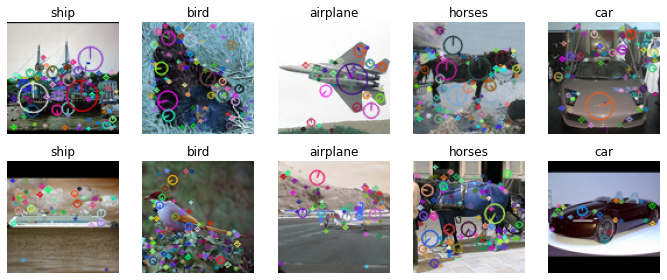

In [55]:
plot_keypoints()

In [7]:
import pandas as pd
def plot_histogram(feature, n):
    label = [1,2,3,7,9]
    label_title = ['airplane', 'bird',  'car', 'horses', 'ship']
    plt.figure(figsize=(30,20))
    plt.style.use("seaborn-darkgrid")
    for index, i in enumerate(label):
        if i == 1:
            j = np.arange(0, 250)
        elif i == 2:
            j = np.arange(250, 500)
        elif i == 3:
            j = np.arange(500, 750)
        elif i == 7:
            j = np.arange(750, 1000)
        elif i == 9:
            j = np.arange(1000, 1250)
            
        frequency = 0
        for k in j:
            frequency += feature[k]
#         frequency /= sum(frequency)
#         print(frequency)
        plt.subplot(2, 3, index+1)
#         plt.hist(data[0], n)
        plt.bar(x=np.arange(0, 2000), height=frequency)
        plt.title(label_title[index], size=49)
        plt.ylabel('Frequency', fontsize=23)
        plt.xlabel('Cluster', fontsize=23)
#     plt.savefig('plot_histogram_2000', bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_rank(top, bottom):
    titles = ['airplane', 'bird',  'car', 'horses', 'ship']
    plt.figure(figsize=(30,30))
    for index, i in enumerate(top):
        plt.subplot(5, 5, index+1)
        plt.imshow(i)
        plt.axis('off')
        plt.title(titles[int(index/5)], fontsize =23)
    print('---Top 5 of each class---')
#     plt.savefig('top_5_500_hog', bbox_inches='tight', pad_inches=0)
    plt.show()
    
    plt.figure(figsize=(30,30))
    for index, i in enumerate(bottom):
        plt.subplot(5, 5, index+1)
        plt.imshow(i)
        plt.axis('off')
        plt.title(titles[int(index/5)], fontsize =23)
    print('---Bottom 5 of each class---')
#     plt.savefig('bottom_5_500_hog', bbox_inches='tight', pad_inches=0)
    plt.show()

---Start classification---
---Loding images---
---Loding success---
---Extract feature---
---Extract Success---
---Build Visual Vocabulary---
---Build success---
---Encode feature---
---Encode success---
---Plot histogram---
---Train classification model---
---Class: 1---
---SVM model training---
---Training success---
---Predict---
---Evaluate results and describe---
Accuracy:  0.83775
mAP:  0.5920248246949578
---Class: 2---
---SVM model training---
---Training success---
---Predict---
---Evaluate results and describe---
Accuracy:  0.8425
mAP:  0.6772828721882537
---Class: 3---
---SVM model training---
---Training success---
---Predict---
---Evaluate results and describe---
Accuracy:  0.8245
mAP:  0.6247239528820633
---Class: 7---
---SVM model training---
---Training success---
---Predict---
---Evaluate results and describe---
Accuracy:  0.8745
mAP:  0.7600437120895132
---Class: 9---
---SVM model training---
---Training success---
---Predict---
---Evaluate results and describe---
Accu

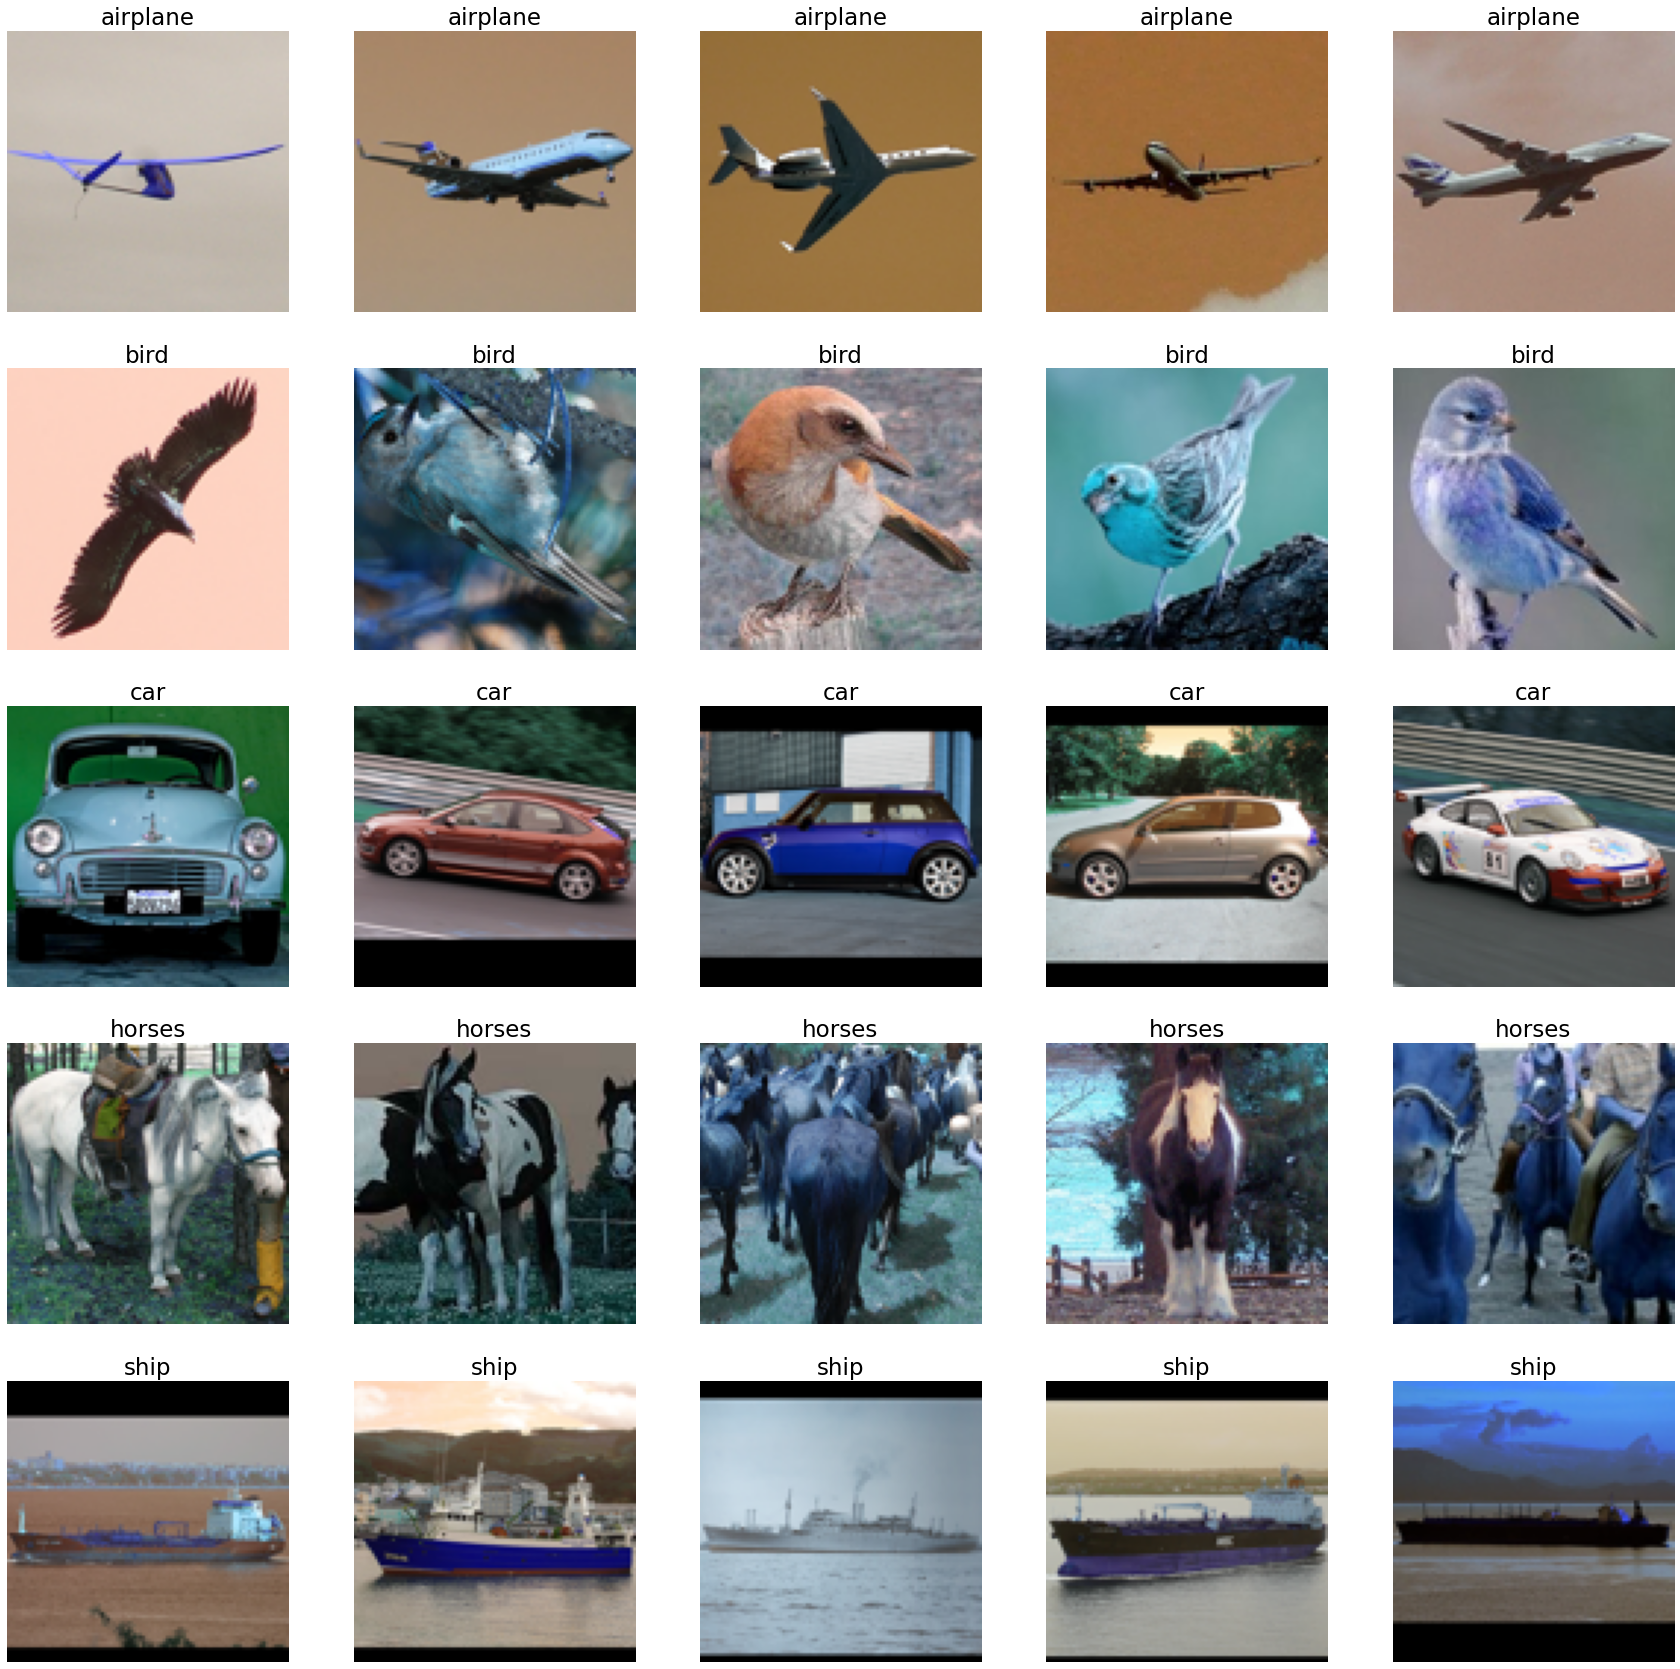

---Bottom 5 of each class---


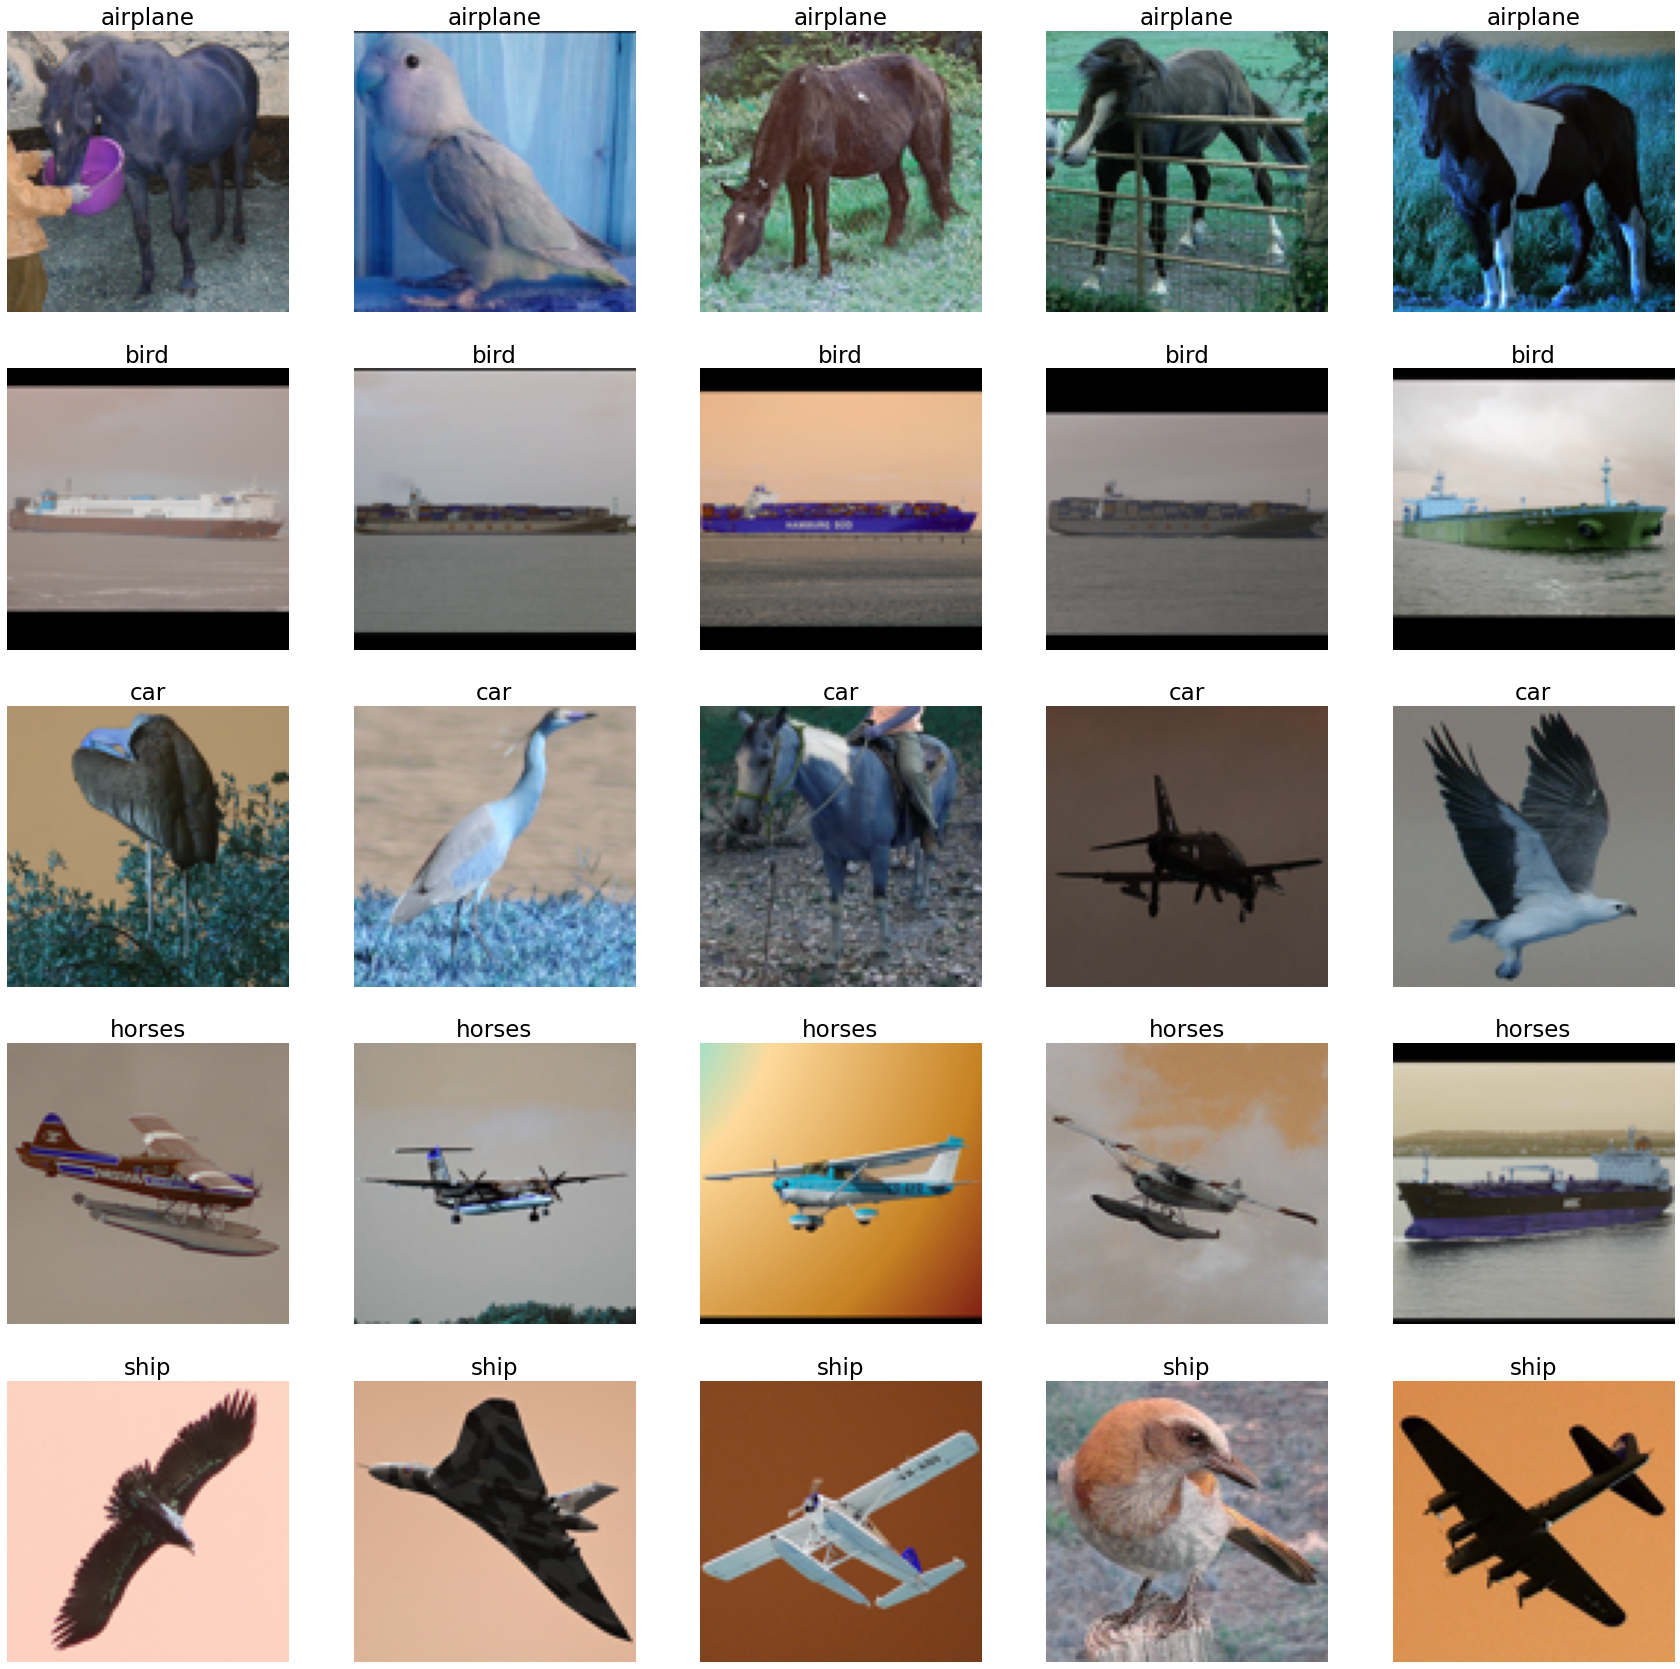

---Done---


In [23]:
if __name__ == "__main__":
    # Assign parameters
    cluster_size = 500
    #Take a subset (maximum half) of all training images, extract SIFT descriptors from all of these images
    subset = 250
    method = 'HOG'
    # label = ['airplane', 'bird',  'car', 'horses', 'ship']
    label = [1,2,3,7,9]
    
    #Start classification
    print('---Start classification---')
    print('---Loding images---')
    train = load_train_images('./train')
    print('---Loding success---')
    print('---Extract feature---')
    x_list, y_list, des_list = feature_extraction(train, subset, method)
    print('---Extract Success---')
    print('---Build Visual Vocabulary---')
    ulabel, vocabulary, KMmodel = build_visual_vocabulary(cluster_size, des_list)
    print('---Build success---')
    print('---Encode feature---')
    feature = encode(x_list, vocabulary, KMmodel, cluster_size)
    n_feature = normalize(feature)
#     print(feature.shape)
    print('---Encode success---')
    print('---Plot histogram---')
#     plot_histogram(feature, cluster_size)
    
    # train classification model
    print('---Train classification model---')
    test = load_train_images('./test')
    x_test, y_test, _ = feature_extraction(test, 0, method)
    feature_test = encode(x_test, vocabulary, KMmodel, cluster_size)
    feature_test = normalize(feature_test)
    top = []
    bottom = []
    for i in label:
        print('---Class: {}---'.format(i))
        y_train = preprocessing_data(y_list, i)
#         print(np.unique(np.array(y_train)))
        print('---SVM model training---')
        SVMmodel = SVM(n_feature, y_train)
        print('---Training success---')
        print('---Predict---')
        y_test_ = preprocessing_data(y_test, i)
        svm_predict(SVMmodel, feature_test, y_test_)
        toplist, bottomlist = rank(SVMmodel, feature_test)
        top.extend(toplist)
        bottom.extend(bottomlist)
    print('---Finish classification---')
    print('---Qualitative evaluation---')
    plot_rank(top, bottom)
    print('---Done---')

AttributeError: 'PathCollection' object has no property 'ulabel'

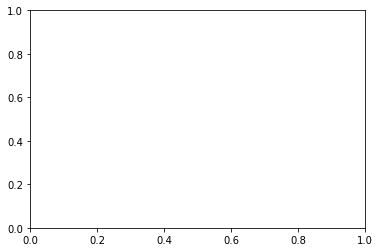

In [29]:
u_labels = np.unique(ulabel)
 
#plotting the results:
des_list = np.array(des_list)
for i in u_labels:
    plt.scatter(des_list[ulabel == i , 0] , des_list[ulabel == i , 1] , ulabel = i)
plt.scatter(vocabulary[:,0] , vocabulary[:,1] , s = 80, color = 'k')
plt.legend()
plt.savefig('plot_kmeans', bbox_inches='tight', pad_inches=0)          
plt.show()

In [15]:
img = cv2.imread('./train/1/4.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#find key points using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray,None)
print(des1.shape)
# img=cv2.drawKeypoints(gray,kp1,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

(32, 128)


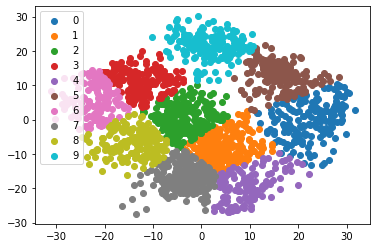

In [28]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
data = load_digits().data
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(data)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 10)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()